<a href="https://colab.research.google.com/github/soutrik71/pytorch_classics/blob/main/AP_Torch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is all about discussion on
1. Cnn Model Basic Setup
2. Application of regularization and dropout
3. Application of batch normalization
4. Application of adaptive learning rate and ReduceLRonPlateau
5. Application of Early stoping and Checkpoints
6. Weights initialization



In [7]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [8]:
!pip install torchview
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 7.7 MB/s eta 0:00:00


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR, ExponentialLR

In [10]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [11]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [12]:
# decorator function to record time exp
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

## Simple Convolution Networks

we will first start with a fashion- MNIST stands for Modified National Institute of Standards and Technology.simple cnn model and keep builing futher one with advancements

In [13]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 128
epochs = 10
lr = 1e-3

Random seed set as 42
cpu


##### Dataloading and Explorations

In [14]:
# reading the data
train_data = datasets.FashionMNIST(root="./data", train=True, download=True, transform=ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root="./data", train=False, download=True, transform=ToTensor(), target_transform=None)

100%|██████████| 26421880/26421880 [00:00<00:00, 116722415.40it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5277974.10it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 64635157.31it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10949430.52it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [15]:
print(train_data.data.shape)
single_image,label = train_data[0]
print(single_image.shape)

torch.Size([60000, 28, 28])
torch.Size([1, 28, 28])


The shape of the image tensor is [1, 28, 28] or more specifically:

[color_channels=1, height=28, width=28]

In [16]:
class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


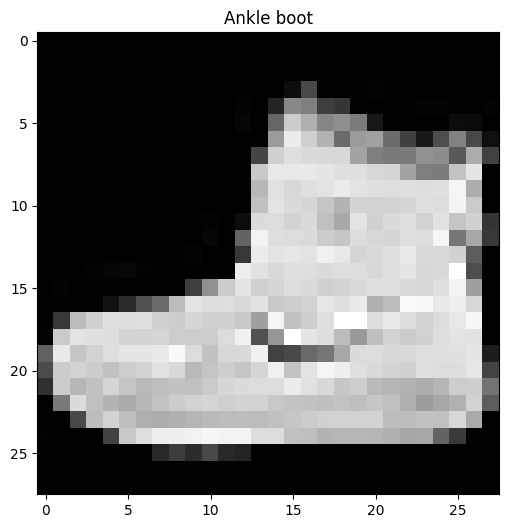

In [17]:
plt.figure(figsize=(6,6))
plt.title(class_names[label])
plt.imshow(single_image.squeeze(), cmap="gray")
plt.show()

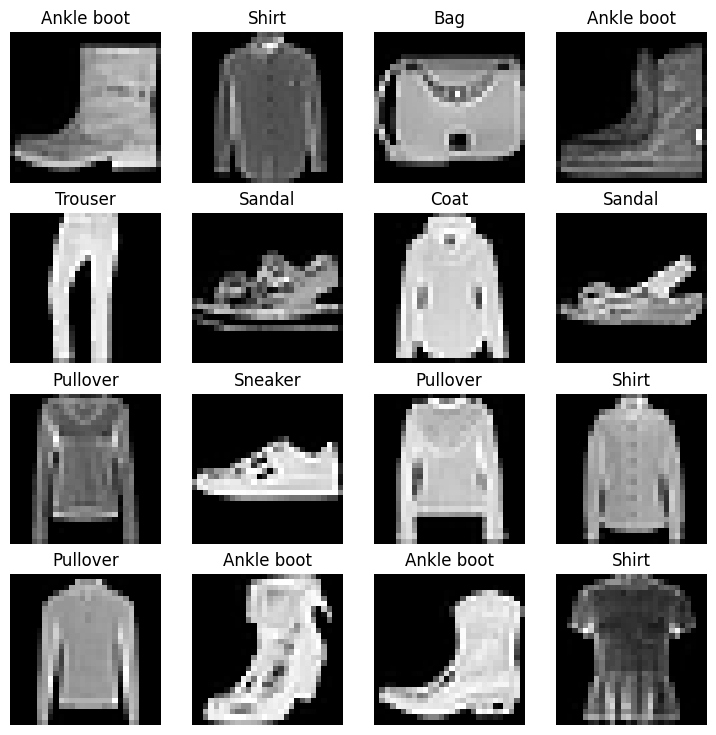

In [18]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [19]:
# dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [20]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [21]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=15,
                       fig_size=(16, 8), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()


##### Model Building

In [16]:
class FashionMnistModel(nn.Module):
    def __init__(self, in_channels, hidden_units, out_channels):
        super(FashionMnistModel, self).__init__()
        # Input starts with (28,28)
        # each conv block is like [conv->relu->conv->relu->maxpool]

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(26,26,HDUN)
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels= hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0
            ), #(24,24,HDUN)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)) #(12,12,HDUN)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(10,10,HDUN)

            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels =hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(8,8,HDUN)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)) #(4,4,HDUN)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*hidden_units, out_channels)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x




In [17]:
fas_model = FashionMnistModel(in_channels=1, hidden_units=8, out_channels=10)
fas_model.to(device)
print(fas_model)

FashionMnistModel(
  (block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
summary(fas_model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3            [-1, 8, 24, 24]             584
              ReLU-4            [-1, 8, 24, 24]               0
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Conv2d-6            [-1, 8, 10, 10]             584
              ReLU-7            [-1, 8, 10, 10]               0
            Conv2d-8              [-1, 8, 8, 8]             584
              ReLU-9              [-1, 8, 8, 8]               0
        MaxPool2d-10              [-1, 8, 4, 4]               0
          Flatten-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 3,122
Trainable params: 3,122
Non-trainable params: 0
-----------------------------------

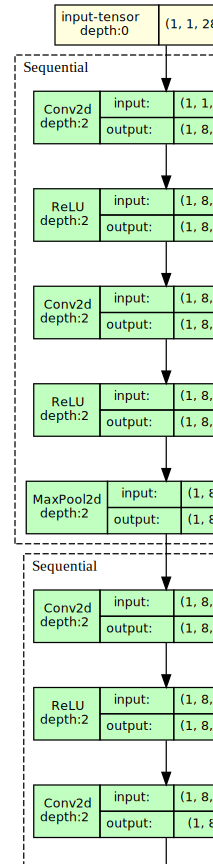

In [ ]:
# graphical representation of the model architecture
model_graph = draw_graph(fas_model, input_size=(1,1, 28, 28), expand_nested=True)
model_graph.resize_graph(scale=10)
model_graph.visual_graph

In [ ]:
# updated training module---
@timeit
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [ ]:
# updated testing modules
@timeit
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [ ]:
# driver setup
optimizer = optim.Adam(fas_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=10)

In [ ]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(fas_model, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(fas_model, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 0.911607165199353 Avg Train Metric: 0.516574881748477: 100%|██████████| 469/469 [00:19<00:00, 24.17it/s]


Function Took 19.4130 seconds


Avg Test Loss: 0.6335252828990356 Avg Test Metric: 0.7818777161308482: 100%|██████████| 79/79 [00:01<00:00, 59.65it/s]


Function Took 1.3329 seconds
Epoch 1


Avg Train Loss: 0.5637907906890169 Avg Train Metric: 0.7873620896705432: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]


Function Took 20.4707 seconds


Avg Test Loss: 0.5476646668548826 Avg Test Metric: 0.8071120562432688: 100%|██████████| 79/79 [00:01<00:00, 42.72it/s]


Function Took 1.8586 seconds
Epoch 2


Avg Train Loss: 0.5059604436985211 Avg Train Metric: 0.81239503100991: 100%|██████████| 469/469 [00:18<00:00, 25.65it/s]


Function Took 18.2967 seconds


Avg Test Loss: 0.510980806773222 Avg Test Metric: 0.8196594783022434: 100%|██████████| 79/79 [00:02<00:00, 31.72it/s]


Function Took 2.5013 seconds
Epoch 3


Avg Train Loss: 0.47722678188321943 Avg Train Metric: 0.8231776818029408: 100%|██████████| 469/469 [00:14<00:00, 32.15it/s]


Function Took 14.6044 seconds


Avg Test Loss: 0.4918481937692135 Avg Test Metric: 0.8189513509786581: 100%|██████████| 79/79 [00:01<00:00, 57.89it/s]


Function Took 1.3719 seconds
Epoch 4


Avg Train Loss: 0.4568185489187871 Avg Train Metric: 0.8336852740631429: 100%|██████████| 469/469 [00:11<00:00, 39.24it/s]


Function Took 11.9615 seconds


Avg Test Loss: 0.4704117733466474 Avg Test Metric: 0.8347121197966081: 100%|██████████| 79/79 [00:02<00:00, 32.54it/s]


Function Took 2.4356 seconds
Epoch 5


Avg Train Loss: 0.441685229984682 Avg Train Metric: 0.8413351328134029: 100%|██████████| 469/469 [00:16<00:00, 28.31it/s]


Function Took 16.5786 seconds


Avg Test Loss: 0.4562679453741146 Avg Test Metric: 0.8323784546007084: 100%|██████████| 79/79 [00:01<00:00, 54.36it/s]


Function Took 1.4614 seconds
Epoch 6


Avg Train Loss: 0.4280499436898526 Avg Train Metric: 0.8440412192710681: 100%|██████████| 469/469 [00:15<00:00, 30.69it/s]


Function Took 15.2926 seconds


Avg Test Loss: 0.43945607241195966 Avg Test Metric: 0.8424101321003105: 100%|██████████| 79/79 [00:01<00:00, 43.53it/s]


Function Took 1.8319 seconds
Epoch 7


Avg Train Loss: 0.4180341127203472 Avg Train Metric: 0.8485922940504322: 100%|██████████| 469/469 [00:16<00:00, 28.96it/s]


Function Took 16.2091 seconds


Avg Test Loss: 0.4287463458655756 Avg Test Metric: 0.8421892516220673: 100%|██████████| 79/79 [00:01<00:00, 59.90it/s]


Function Took 1.3255 seconds
Epoch 8


Avg Train Loss: 0.4064589488480899 Avg Train Metric: 0.8526746612876209: 100%|██████████| 469/469 [00:12<00:00, 37.82it/s]


Function Took 12.4105 seconds


Avg Test Loss: 0.42264461441885065 Avg Test Metric: 0.850897867468339: 100%|██████████| 79/79 [00:01<00:00, 59.44it/s]


Function Took 1.3351 seconds
Epoch 9


Avg Train Loss: 0.39581939072878375 Avg Train Metric: 0.855885082978938: 100%|██████████| 469/469 [00:12<00:00, 36.19it/s]


Function Took 12.9676 seconds


Avg Test Loss: 0.4318585505213919 Avg Test Metric: 0.8483479724654669: 100%|██████████| 79/79 [00:01<00:00, 45.49it/s]

Function Took 1.7435 seconds


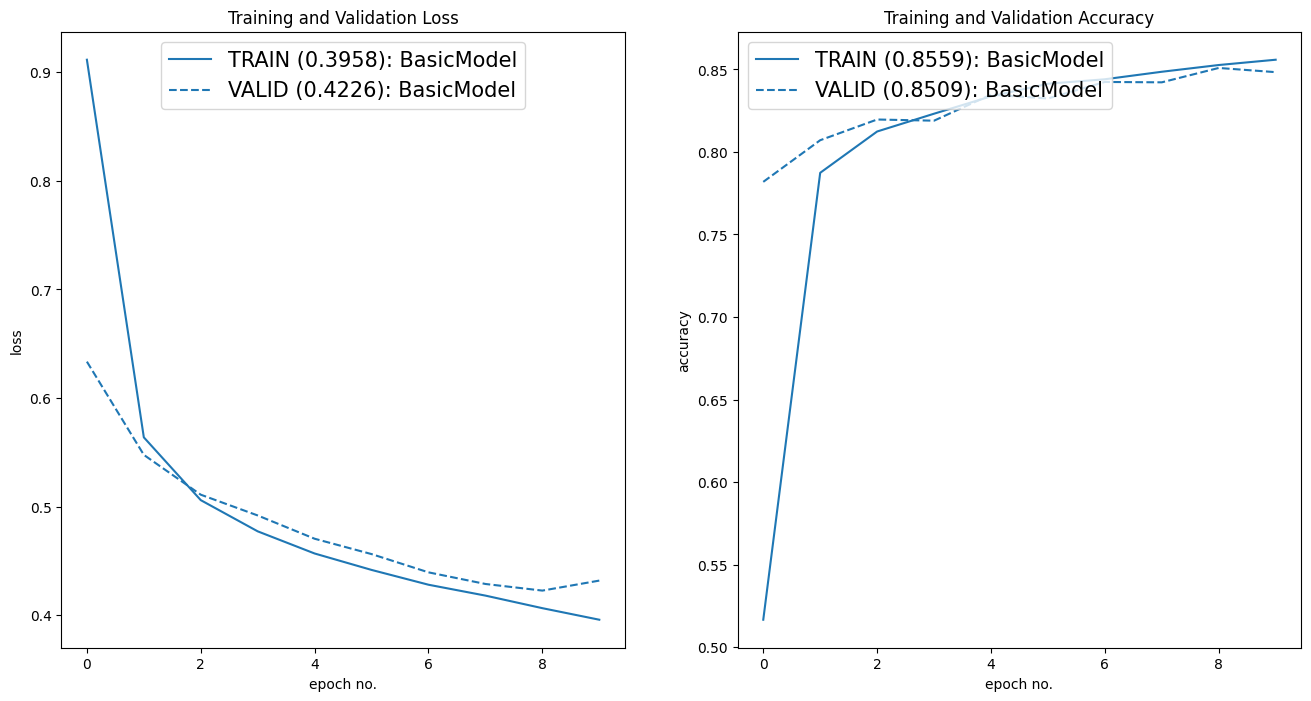

In [ ]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['BasicModel'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

#### Model Testing

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
  """Make predictions for sample records"""
  pred_labels = []
  model.eval()
  with torch.inference_mode():
      for sample in data:
          # Prepare sample
          sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device
          # print(sample.shape)
          # Forward pass (model outputs raw logit)
          pred_logit = model(sample)

          # Get prediction probability (logit -> prediction probability)
          pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)
          # print(pred_prob.shape) [10]
          pred_classes = pred_prob.argmax().detach().cpu().item()
          # Get pred_prob off GPU for further calculations
          pred_labels.append(pred_classes)

  # Stack the pred_probs to turn list into a tensor
  return pred_labels

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=2):
    test_samples.append(sample)
    test_labels.append(label)


In [ ]:
pred_labels = make_predictions(fas_model, test_samples, device=device)

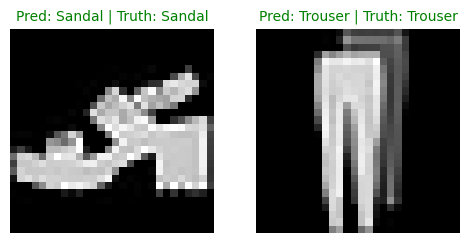

In [ ]:
pred_labels# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_labels[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

For testing metrics we will revisit the logics when we discuss about Torch Metrics in details

## Regularization

regularization is a technique that helps reduce overfitting or reduce variance in our network by penalizing for complexity. The idea is that certain complexities in our model may make our model unlikely to generalize well even though it fits the training data. If we add regularization to the model we’re essentially trading in some of the ability of our model to fit the training data as well as the ability to have the model generalize better to data it hasn’t seen before.

L1 Regularization: Needs to be added as a functionality to be added to the loss function

! [picture](https://androidkt.com/wp-content/uploads/2021/09/L1-Regula.png)

L2 Regularization: Can be added as a functionality to be added to the loss function or as an arg in optimizer

! [picture](https://androidkt.com/wp-content/uploads/2021/09/l2_regula.png)

https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-pytorch.md

https://androidkt.com/how-to-add-l1-l2-regularization-in-pytorch-loss-function/

In [22]:
def regularization(model , reg_type, reg_coeff):
  """Model regularization"""
  loss_params = []
  for parameter in model.parameters():
    loss_params.append(parameter.view(-1))

  if reg_type == "l1":
    reg_factor = reg_coeff * model.l1_loss(torch.cat(loss_params))
    return reg_factor
  elif reg_type == "l2":
    reg_factor = reg_coeff * model.l2_loss(torch.cat(loss_params))
    return reg_factor
  elif reg_type is None:
    return 0

In [ ]:
class FashionMnistModelReg(nn.Module):
    """Feedfoward neural network with 2 Cnn blocks and 1 hidden layer"""
    def __init__(self, in_channels, hidden_units, out_channels):
        super(FashionMnistModelReg, self).__init__()
        # Input starts with (28,28)
        # each conv block is like [conv->relu->conv->relu->maxpool]

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(26,26,HDUN)
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels= hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0
            ), #(24,24,HDUN)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)) #(12,12,HDUN)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(10,10,HDUN)

            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels =hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(8,8,HDUN)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)) #(4,4,HDUN)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*hidden_units, out_channels)
        )

    def forward(self, x):
      """Forward propagation"""
      x = self.block1(x)
      x = self.block2(x)
      x = self.classifier(x)

      return x

    def l1_loss(self, w):
      """Compute l1 loss"""
      return torch.abs(w).sum()

    def l2_loss(self, w):
      """Compute l2 loss"""
      return torch.square(w).sum()

In [ ]:
# l2_parameters = []
# for parameter in fas_model2.parameters():
#   print(parameter.shape)
#   print(parameter.view(-1).shape)
#   # print(parameter.flatten().shape) #same as abv
#   l2_parameters.append(parameter.view(-1))

# fas_model2.l1_loss(torch.cat(l2_parameters))

In [ ]:
# updated training module---
@timeit
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list,
                 reg_type:str,
                 reg_coeff:float):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    # regularization
    reg_factor = regularization(model, reg_type, reg_coeff)
    loss += reg_factor
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")


    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [ ]:
@timeit
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      # no need for calculating regularization
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [ ]:
fas_model2 = FashionMnistModelReg(in_channels=1,
                               hidden_units=8,
                               out_channels=10)
fas_model2.to(device)

FashionMnistModelReg(
  (block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
summary(fas_model2, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3            [-1, 8, 24, 24]             584
              ReLU-4            [-1, 8, 24, 24]               0
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Conv2d-6            [-1, 8, 10, 10]             584
              ReLU-7            [-1, 8, 10, 10]               0
            Conv2d-8              [-1, 8, 8, 8]             584
              ReLU-9              [-1, 8, 8, 8]               0
        MaxPool2d-10              [-1, 8, 4, 4]               0
          Flatten-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 3,122
Trainable params: 3,122
Non-trainable params: 0
-----------------------------------

In [ ]:
# driver setup
reg_type="l2"
reg_coeff=0.001
if reg_type is not None:
  optimizer = optim.Adam(fas_model2.parameters(), lr=lr)
else:
  # adding l2 reg within optimizer only 3 works exactly same as adding l2 loss with the actual loss
  optimizer = optim.Adam(fas_model2.parameters(), lr=lr, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=10)

In [ ]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(fas_model2, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics, reg_type, reg_coeff)
  test_losses , test_metrics = test_module(fas_model2, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 0.8713298304629987 Avg Train Metric: 0.5428468260620194: 100%|██████████| 469/469 [00:15<00:00, 29.45it/s]


Function Took 15.9320 seconds


Avg Test Loss: 0.6091791579994974 Avg Test Metric: 0.7600521196292925: 100%|██████████| 79/79 [00:01<00:00, 58.98it/s]


Function Took 1.3481 seconds
Epoch 1


Avg Train Loss: 0.5706821095460514 Avg Train Metric: 0.7850807274836721: 100%|██████████| 469/469 [00:12<00:00, 38.31it/s]


Function Took 12.2531 seconds


Avg Test Loss: 0.5320038369184807 Avg Test Metric: 0.7964830315565761: 100%|██████████| 79/79 [00:01<00:00, 56.10it/s]


Function Took 1.4141 seconds
Epoch 2


Avg Train Loss: 0.5151833326323454 Avg Train Metric: 0.816907601315838: 100%|██████████| 469/469 [00:12<00:00, 38.33it/s]


Function Took 12.2447 seconds


Avg Test Loss: 0.4915153387981125 Avg Test Metric: 0.8173137020461166: 100%|██████████| 79/79 [00:01<00:00, 50.92it/s]


Function Took 1.5586 seconds
Epoch 3


Avg Train Loss: 0.48847523674781895 Avg Train Metric: 0.8322561285389003: 100%|██████████| 469/469 [00:12<00:00, 39.00it/s]


Function Took 12.0357 seconds


Avg Test Loss: 0.4535052036937279 Avg Test Metric: 0.8379247920422614: 100%|██████████| 79/79 [00:01<00:00, 47.70it/s]


Function Took 1.6631 seconds
Epoch 4


Avg Train Loss: 0.4699268808115774 Avg Train Metric: 0.8446049139952101: 100%|██████████| 469/469 [00:12<00:00, 37.59it/s]


Function Took 12.4852 seconds


Avg Test Loss: 0.44016523187673545 Avg Test Metric: 0.832497645782519: 100%|██████████| 79/79 [00:01<00:00, 45.16it/s]


Function Took 1.7569 seconds
Epoch 5


Avg Train Loss: 0.4564101000203253 Avg Train Metric: 0.8468904604535621: 100%|██████████| 469/469 [00:11<00:00, 39.29it/s]


Function Took 11.9455 seconds


Avg Test Loss: 0.41955337758305705 Avg Test Metric: 0.8507383827921711: 100%|██████████| 79/79 [00:01<00:00, 43.24it/s]


Function Took 1.8343 seconds
Epoch 6


Avg Train Loss: 0.4446557305896206 Avg Train Metric: 0.8508168963481114: 100%|██████████| 469/469 [00:12<00:00, 37.90it/s]


Function Took 12.3803 seconds


Avg Test Loss: 0.4026242404044429 Avg Test Metric: 0.8585440478747404: 100%|██████████| 79/79 [00:01<00:00, 43.82it/s]


Function Took 1.8112 seconds
Epoch 7


Avg Train Loss: 0.43330325148125953 Avg Train Metric: 0.857038212229194: 100%|██████████| 469/469 [00:13<00:00, 35.96it/s]


Function Took 13.0470 seconds


Avg Test Loss: 0.4155602892742881 Avg Test Metric: 0.8476296218135689: 100%|██████████| 79/79 [00:01<00:00, 57.50it/s]


Function Took 1.3819 seconds
Epoch 8


Avg Train Loss: 0.42551867381087755 Avg Train Metric: 0.8618694041837761: 100%|██████████| 469/469 [00:12<00:00, 38.28it/s]


Function Took 12.2602 seconds


Avg Test Loss: 0.40933259114434445 Avg Test Metric: 0.8511865508707264: 100%|██████████| 79/79 [00:01<00:00, 58.93it/s]


Function Took 1.3494 seconds
Epoch 9


Avg Train Loss: 0.4196040359005999 Avg Train Metric: 0.8668960687448221: 100%|██████████| 469/469 [00:12<00:00, 38.65it/s]


Function Took 12.1430 seconds


Avg Test Loss: 0.396529040853434 Avg Test Metric: 0.8563358663003656: 100%|██████████| 79/79 [00:01<00:00, 60.52it/s]

Function Took 1.3146 seconds


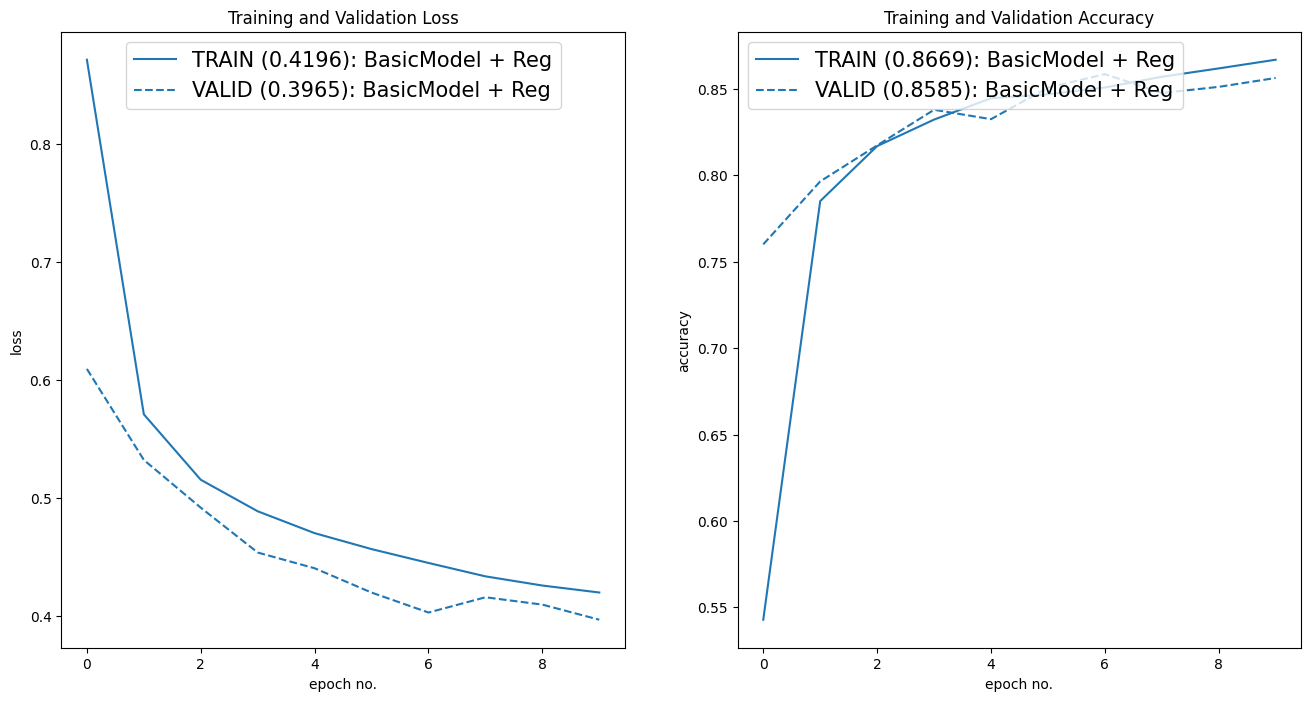

In [ ]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['BasicModel+Reg'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

## DROPOUTS

Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

In PyTorch, the dropout layer further scale the resulting tensor by a factor of 1/(1-p),
so the average tensor value is maintained. Thanks to this scaling, the dropout layer operates at inference will be an identify function (i.e., no effect, simply copy over the input tensor as output tensor). You should make sure to turn the model into inference mode when evaluating the the model.

https://medium.com/artificialis/dropout-regularization-using-pytorch-in-python-7765337cb158

https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models/

In [ ]:
class FashionMnistModelRegDropout(nn.Module):
    """Feedfoward neural network with 2 Cnn blocks and 1 hidden layer"""
    def __init__(self, in_channels, hidden_units, out_channels):
        super(FashionMnistModelRegDropout, self).__init__()
        # Input starts with (28,28)
        # each conv block is like [conv->relu->conv->relu->maxpool]

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                     padding=0), #(26,26,HDUN)
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels= hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0
            ), #(24,24,HDUN)
            nn.ReLU(),
            nn.Dropout(p=0.1), # droputs after activation function
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)) #(12,12,HDUN)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(10,10,HDUN)
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels =hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(8,8,HDUN)
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)) #(4,4,HDUN)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*hidden_units, out_channels)
        )

        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
      """Forward propagation"""
      x = self.block1(x)
      x = self.block2(x)
      x = self.classifier(x)

      return x

    def l1_loss(self, w):
      """Compute l1 loss"""
      return torch.abs(w).sum()

    def l2_loss(self, w):
      """Compute l2 loss"""
      return torch.square(w).sum()

In [ ]:
fas_model3 = FashionMnistModelRegDropout(in_channels=1,
                                          hidden_units=8,
                                          out_channels=10).to(device)

In [ ]:
# driver setup
reg_type="l2"
reg_coeff=0.0001
if reg_type is not None:
  optimizer = optim.Adam(fas_model3.parameters(), lr=lr)
else:
  # adding l2 reg within optimizer only 3 works exactly same as adding l2 loss with the actual loss
  optimizer = optim.Adam(fas_model3.parameters(), lr=lr, weight_decay=reg_coeff)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=10)

In [ ]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(fas_model3, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics, reg_type, reg_coeff)
  test_losses , test_metrics = test_module(fas_model3, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 0.908041750762 Avg Train Metric: 0.5081525746979185: 100%|██████████| 469/469 [00:12<00:00, 38.30it/s]


Function Took 12.2564 seconds


Avg Test Loss: 0.6895291341256492 Avg Test Metric: 0.7645623472672475: 100%|██████████| 79/79 [00:01<00:00, 44.60it/s]


Function Took 1.7808 seconds
Epoch 1


Avg Train Loss: 0.5957401349092089 Avg Train Metric: 0.7676851524473: 100%|██████████| 469/469 [00:12<00:00, 38.94it/s]


Function Took 12.0526 seconds


Avg Test Loss: 0.586409248128722 Avg Test Metric: 0.797388546074493: 100%|██████████| 79/79 [00:01<00:00, 47.07it/s]


Function Took 1.6847 seconds
Epoch 2


Avg Train Loss: 0.5460335901424066 Avg Train Metric: 0.7956278072491384: 100%|██████████| 469/469 [00:12<00:00, 38.60it/s]


Function Took 12.1593 seconds


Avg Test Loss: 0.5407853960236416 Avg Test Metric: 0.8089435010016719: 100%|██████████| 79/79 [00:01<00:00, 44.31it/s]


Function Took 1.7899 seconds
Epoch 3


Avg Train Loss: 0.5125253164310699 Avg Train Metric: 0.8079709521234671: 100%|██████████| 469/469 [00:12<00:00, 38.96it/s]


Function Took 12.0464 seconds


Avg Test Loss: 0.49707211044770255 Avg Test Metric: 0.8261135839208772: 100%|██████████| 79/79 [00:01<00:00, 45.26it/s]


Function Took 1.7572 seconds
Epoch 4


Avg Train Loss: 0.48627725364302776 Avg Train Metric: 0.8210216212882671: 100%|██████████| 469/469 [00:13<00:00, 35.05it/s]


Function Took 13.3884 seconds


Avg Test Loss: 0.4731389812276333 Avg Test Metric: 0.8308931770203989: 100%|██████████| 79/79 [00:01<00:00, 59.42it/s]


Function Took 1.3362 seconds
Epoch 5


Avg Train Loss: 0.4647477399438683 Avg Train Metric: 0.8295469013358484: 100%|██████████| 469/469 [00:12<00:00, 37.79it/s]


Function Took 12.4222 seconds


Avg Test Loss: 0.46037776334376274 Avg Test Metric: 0.8385181291193902: 100%|██████████| 79/79 [00:01<00:00, 58.32it/s]


Function Took 1.3624 seconds
Epoch 6


Avg Train Loss: 0.44495535640320033 Avg Train Metric: 0.8373565161660281: 100%|██████████| 469/469 [00:12<00:00, 38.02it/s]


Function Took 12.3439 seconds


Avg Test Loss: 0.4439464305775075 Avg Test Metric: 0.8485947832276549: 100%|██████████| 79/79 [00:01<00:00, 58.23it/s]


Function Took 1.3654 seconds
Epoch 7


Avg Train Loss: 0.4335214334891549 Avg Train Metric: 0.8424015650108679: 100%|██████████| 469/469 [00:12<00:00, 37.92it/s]


Function Took 12.3783 seconds


Avg Test Loss: 0.43770020521139796 Avg Test Metric: 0.8576116033747226: 100%|██████████| 79/79 [00:01<00:00, 59.35it/s]


Function Took 1.3396 seconds
Epoch 8


Avg Train Loss: 0.4238172521723359 Avg Train Metric: 0.846391929492259: 100%|██████████| 469/469 [00:12<00:00, 38.07it/s]


Function Took 12.3288 seconds


Avg Test Loss: 0.41730561399761634 Avg Test Metric: 0.8568222620819188: 100%|██████████| 79/79 [00:01<00:00, 59.61it/s]


Function Took 1.3319 seconds
Epoch 9


Avg Train Loss: 0.4141222570877848 Avg Train Metric: 0.8513356358257692: 100%|██████████| 469/469 [00:12<00:00, 37.76it/s]


Function Took 12.4309 seconds


Avg Test Loss: 0.4087710629535627 Avg Test Metric: 0.8617426451248459: 100%|██████████| 79/79 [00:01<00:00, 58.75it/s]

Function Took 1.3515 seconds


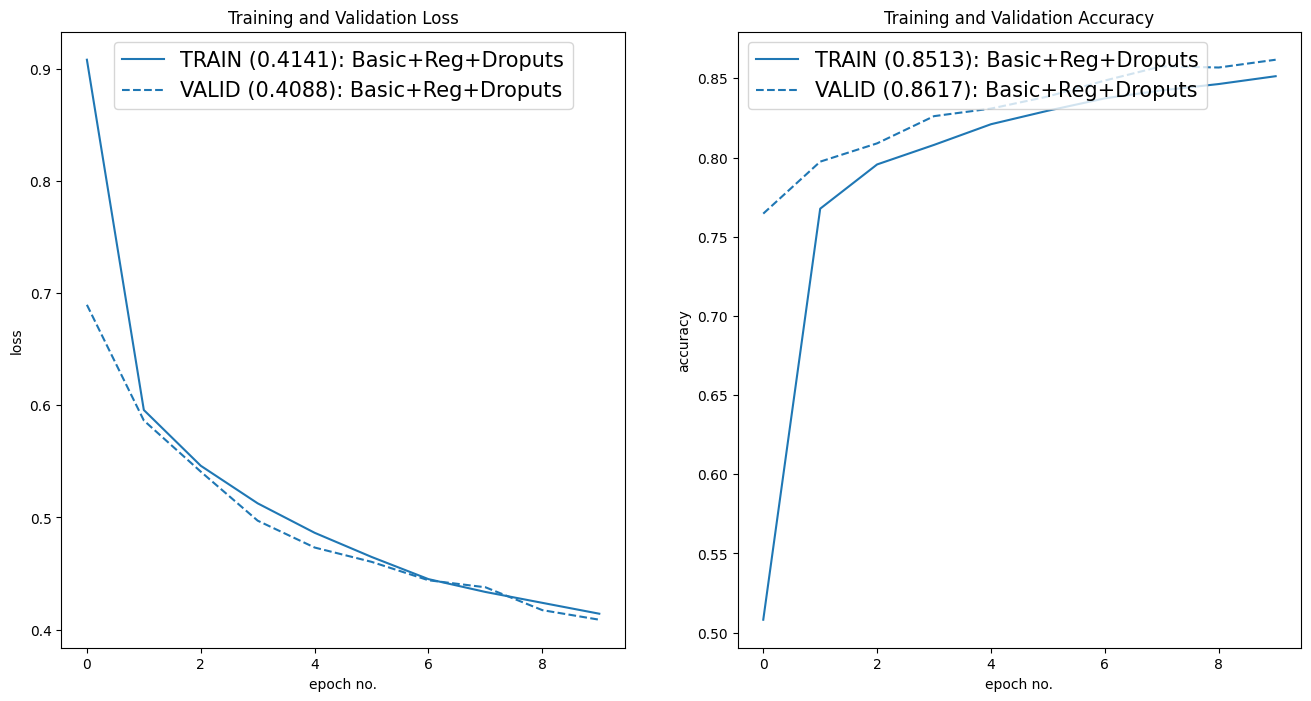

In [ ]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['Basic+Reg+Droputs'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

## BatchNormalization

In order to bring all the activation values to the same scale, we normalize the activation values such that the hidden representation doesn’t vary drastically and also helps us to get improvement in the training speed.

Since we are computing the mean and standard deviation from a single batch as opposed to computing it from the entire data. Batch normalization is done individually at each hidden neuron in the network.


Since we are computing the mean and standard deviation from a single batch as opposed to computing it from the entire data. Batch normalization is done individually at each hidden neuron in the network.

The parameters Gamma and Beta are learned along with other parameters of the network. If Gamma (γ) is equal to the mean (μ) and Beta (β) is equal to the standard deviation(σ) then the activation h_final is equal to the h_norm, thus preserving the representative power of the network.

https://miro.medium.com/v2/resize:fit:640/format:webp/1*geAUoGkykqQ-H0OTqIgbFA.png

https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#batchnorm1d

Order of Batch Norm Activation and Dropout

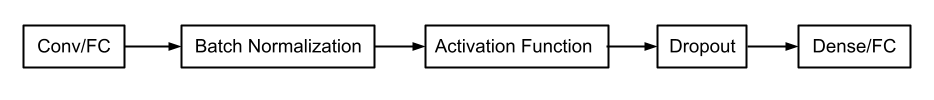

https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout#:~:text=Usually%2C%20Just%20drop%20the%20Dropout,not%20using%20Dropout

https://androidkt.com/where-should-place-dropout-batch-normalization-and-activation-layer/

In [ ]:
class FashionMnistModelRegDropoutBN(nn.Module):
    """Feedfoward neural network with 2 Cnn blocks and 1 hidden layer"""
    def __init__(self, in_channels, hidden_units, out_channels):
        super(FashionMnistModelRegDropoutBN, self).__init__()
        # Input starts with (28,28)
        # each conv block is like [conv->relu->conv->relu->maxpool]

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                     padding=0), #(26,26,HDUN)
            nn.BatchNorm2d(hidden_units),  # BN before activation
            nn.ReLU(),
            nn.Dropout(p=0.1),  # droputs after activation function

            nn.Conv2d(in_channels = hidden_units,
                      out_channels= hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0
            ), #(24,24,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)) #(12,12,HDUN)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(10,10,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.1),

            nn.Conv2d(in_channels = hidden_units,
                      out_channels =hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(8,8,HDUN)

            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)) #(4,4,HDUN)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*hidden_units, out_channels*10),
            nn.BatchNorm1d(out_channels*10), # 1d BN added as an example
            nn.ReLU(),
            nn.Linear(out_channels*10, out_channels)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

    def forward(self, x):
      """Forward propagation"""
      x = self.block1(x)
      x = self.block2(x)
      x = self.classifier(x)

      return x

    def l1_loss(self, w):
      """Compute l1 loss"""
      return torch.abs(w).sum()

    def l2_loss(self, w):
      """Compute l2 loss"""
      return torch.square(w).sum()

In [ ]:
fas_model4 = FashionMnistModelRegDropoutBN(in_channels=1,
                                           hidden_units=8,
                                           out_channels=10).to(device)
summary(fas_model4, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
       BatchNorm2d-6            [-1, 8, 24, 24]              16
              ReLU-7            [-1, 8, 24, 24]               0
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 10, 10]             584
      BatchNorm2d-11            [-1, 8, 10, 10]              16
             ReLU-12            [-1, 8, 10, 10]               0
          Dropout-13            [-1, 8, 10, 10]               0
           Conv2d-14              [-1, 

In [ ]:
# driver setup
reg_type="l2"
reg_coeff=0.0001
if reg_type is not None:
  optimizer = optim.Adam(fas_model4.parameters(), lr=lr)
else:
  # adding l2 reg within optimizer only 3 works exactly same as adding l2 loss with the actual loss
  optimizer = optim.Adam(fas_model4.parameters(), lr=lr, weight_decay=reg_coeff)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=10)

In [ ]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(fas_model4, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics, reg_type, reg_coeff)
  test_losses , test_metrics = test_module(fas_model4, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 0.6401320868082392 Avg Train Metric: 0.7016067252293833: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]


Function Took 13.9420 seconds


Avg Test Loss: 0.44017757267891605 Avg Test Metric: 0.8445438780362093: 100%|██████████| 79/79 [00:01<00:00, 59.90it/s]


Function Took 1.3261 seconds
Epoch 1


Avg Train Loss: 0.4071364771963945 Avg Train Metric: 0.8556050421840855: 100%|██████████| 469/469 [00:13<00:00, 35.28it/s]


Function Took 13.2988 seconds


Avg Test Loss: 0.3752994963639899 Avg Test Metric: 0.8636050375202035: 100%|██████████| 79/79 [00:01<00:00, 59.48it/s]


Function Took 1.3365 seconds
Epoch 2


Avg Train Loss: 0.36736630678558146 Avg Train Metric: 0.8721026410934514: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]


Function Took 13.4696 seconds


Avg Test Loss: 0.37889849611475496 Avg Test Metric: 0.8612898625905001: 100%|██████████| 79/79 [00:01<00:00, 59.71it/s]


Function Took 1.3296 seconds
Epoch 3


Avg Train Loss: 0.35021629541921717 Avg Train Metric: 0.8779856450776301: 100%|██████████| 469/469 [00:13<00:00, 35.04it/s]


Function Took 13.3916 seconds


Avg Test Loss: 0.36314222329779516 Avg Test Metric: 0.8703648908228814: 100%|██████████| 79/79 [00:01<00:00, 59.17it/s]


Function Took 1.3436 seconds
Epoch 4


Avg Train Loss: 0.3342161301864998 Avg Train Metric: 0.8872224232281195: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]


Function Took 13.4695 seconds


Avg Test Loss: 0.34909254595448697 Avg Test Metric: 0.8734470371958576: 100%|██████████| 79/79 [00:01<00:00, 60.25it/s]


Function Took 1.3209 seconds
Epoch 5


Avg Train Loss: 0.3223294463874435 Avg Train Metric: 0.892125326687339: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]


Function Took 13.8150 seconds


Avg Test Loss: 0.32637728939328015 Avg Test Metric: 0.8819729451891742: 100%|██████████| 79/79 [00:01<00:00, 55.66it/s]


Function Took 1.4270 seconds
Epoch 6


Avg Train Loss: 0.3105537212733775 Avg Train Metric: 0.8946711131250427: 100%|██████████| 469/469 [00:13<00:00, 34.67it/s]


Function Took 13.5334 seconds


Avg Test Loss: 0.3111426558675645 Avg Test Metric: 0.8929625010188622: 100%|██████████| 79/79 [00:01<00:00, 44.16it/s]


Function Took 1.7948 seconds
Epoch 7


Avg Train Loss: 0.30879259236585865 Avg Train Metric: 0.8976976166147668: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]


Function Took 13.6207 seconds


Avg Test Loss: 0.3580145658571509 Avg Test Metric: 0.8679821083817301: 100%|██████████| 79/79 [00:01<00:00, 57.73it/s]


Function Took 1.3755 seconds
Epoch 8


Avg Train Loss: 0.299095835798839 Avg Train Metric: 0.9009900483241213: 100%|██████████| 469/469 [00:13<00:00, 34.68it/s]


Function Took 13.5306 seconds


Avg Test Loss: 0.3485222866263571 Avg Test Metric: 0.8748536389085311: 100%|██████████| 79/79 [00:01<00:00, 57.56it/s]


Function Took 1.3822 seconds
Epoch 9


Avg Train Loss: 0.2931492995224528 Avg Train Metric: 0.9026693331915686: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]


Function Took 13.5926 seconds


Avg Test Loss: 0.3438649288838423 Avg Test Metric: 0.8816045462330685: 100%|██████████| 79/79 [00:01<00:00, 59.28it/s]

Function Took 1.3406 seconds


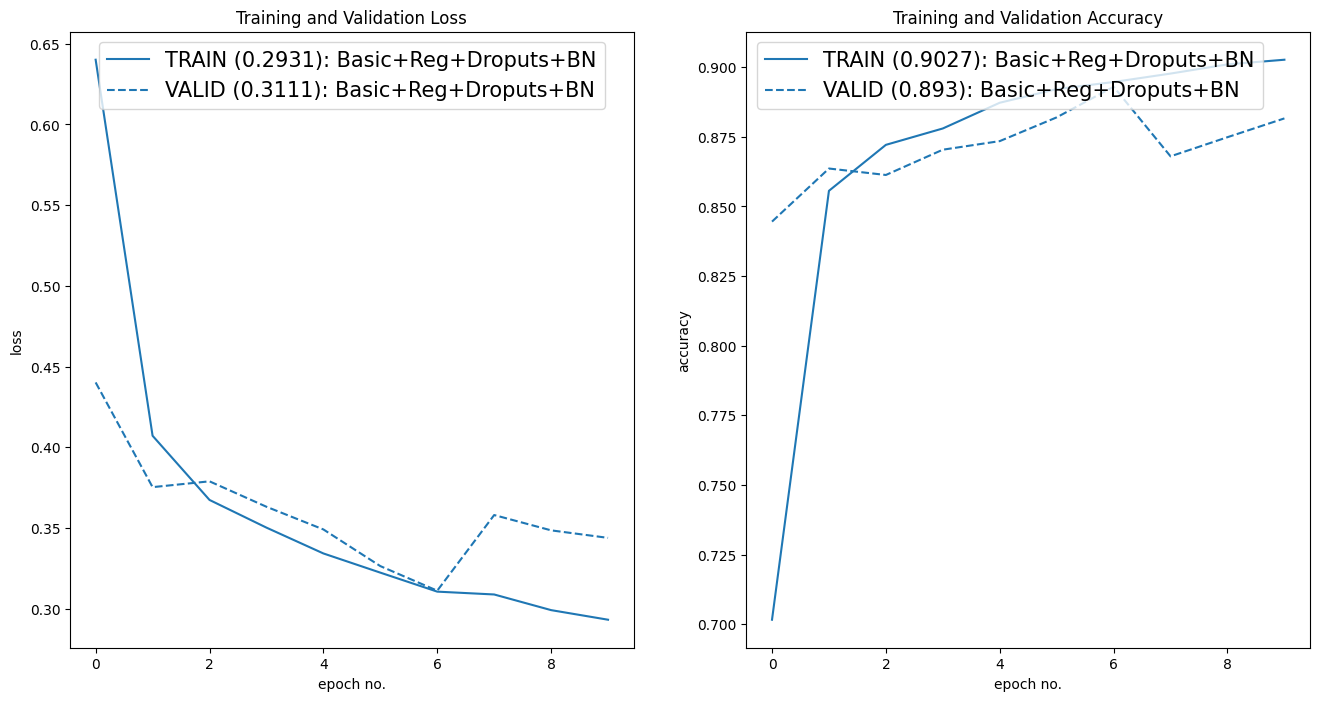

In [ ]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['Basic+Reg+Droputs+BN'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

## ADAPTIVE LEARNING RATE

In the early stages of model training, the model is still making large steps towards the gradient space, and a large learning rate helps it find the coarse values it needs more quickly.
In the late stages of model training, the opposite is true. The model has approximately the right gradients already; it just needs a little extra push to find the last few percentage points of performance. A large gradient is no longer appropriate because it will “overshoot” the point of optimality. Instead of converging on the global cost minima, the model will bounce around it

You can update the learning rate as frequent as each step but usually it is updated once per epoch because you want to know how the network performs in order to determine how the learning rate should update. Regularly, a model is evaluated with validation dataset once per epoch.

There are multiple ways of making learning rate adaptive. At the beginning of training, you may prefer a larger learning rate so you improve the network coarsely to speed up the progress. In a very complex neural network model, you may also prefer to gradually increasse the learning rate at the beginning because you need the network to explore on the different dimensions of prediction. At the end of training, however, you always want to have the learning rate smaller.\
** We use it only in  the training module **

lr_scheduler.LambdaLR\
Sets the learning rate of each parameter group to the initial lr times a given function.

lr_scheduler.MultiplicativeLR\
Multiply the learning rate of each parameter group by the factor given in the specified function.

lr_scheduler.StepLR\
Decays the learning rate of each parameter group by gamma every step_size epochs.

lr_scheduler.MultiStepLR\
Decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.

lr_scheduler.ConstantLR\
Decays the learning rate of each parameter group by a small constant factor until the number of epoch reaches a pre-defined milestone: total_iters.

lr_scheduler.LinearLR\
Decays the learning rate of each parameter group by linearly changing small multiplicative factor until the number of epoch reaches a pre-defined milestone: total_iters.

lr_scheduler.ExponentialLR\
Decays the learning rate of each parameter group by gamma every epoch.

lr_scheduler.PolynomialLR\
Decays the learning rate of each parameter group using a polynomial function in the given total_iters.

lr_scheduler.ChainedScheduler\
Chains list of learning rate schedulers.

lr_scheduler.SequentialLR\
Receives the list of schedulers that is expected to be called sequentially during optimization process and milestone points that provides exact intervals to reflect which scheduler is supposed to be called at a given epoch.

lr_scheduler.ReduceLROnPlateau\
Reduce learning rate when a metric has stopped improving.

lr_scheduler.CyclicLR\
Sets the learning rate of each parameter group according to cyclical learning rate policy (CLR).

lr_scheduler.OneCycleLR\
Sets the learning rate of each parameter group according to the 1cycle learning rate policy.

https://miro.medium.com/v2/resize:fit:828/format:webp/1*qe6nYlH8zsmUdScyHMhRCQ.png

We will experiment with only Step,Exponential and oneCycleLR


https://machinelearningmastery.com/using-learning-rate-schedule-in-pytorch-training/

https://androidkt.com/pytorch-change-the-learning-rate-based-on-epoch/

https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863

In [ ]:
# updated training module wit lr scheduler ---
@timeit
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list,
                 reg_type:str,
                 reg_coeff:float,
                 lr_scheduler):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    # regularization
    reg_factor = regularization(model, reg_type, reg_coeff)
    loss += reg_factor
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")


    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)
  # learning rate scheduler
  print(f'For current epoch lr: {optimizer.param_groups[0]["lr"]}')
  lr_scheduler.step()
  print(f"For next epoch {lr_scheduler.get_last_lr()[0]}")

  return train_losses, train_metrics


In [ ]:
# no updates in test module
@timeit
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      # no need for calculating regularization
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [ ]:
fas_model4 = FashionMnistModelRegDropoutBN(in_channels=1,
                                           hidden_units=8,
                                           out_channels=10).to(device)
summary(fas_model4, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
       BatchNorm2d-6            [-1, 8, 24, 24]              16
              ReLU-7            [-1, 8, 24, 24]               0
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 10, 10]             584
      BatchNorm2d-11            [-1, 8, 10, 10]              16
             ReLU-12            [-1, 8, 10, 10]               0
          Dropout-13            [-1, 8, 10, 10]               0
           Conv2d-14              [-1, 

In [ ]:
# driver setup
reg_type="l2"
reg_coeff=0.0001
lr = 1e-3
#optimizers
if reg_type is not None:
  optimizer = optim.Adam(fas_model4.parameters(), lr=lr)
else:
  # adding l2 reg within optimizer only 3 works exactly same as adding l2 loss with the actual loss
  optimizer = optim.Adam(fas_model4.parameters(), lr=lr, weight_decay=reg_coeff)

#loss metric
criterion = nn.CrossEntropyLoss()

# accuracy metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# diffeent schedulers
step_scheduler = StepLR(optimizer, step_size = 4, # Period of learning rate decay
                   gamma = 0.5) # Multiplicative factor of learning rate decay

In [ ]:
# Place holders---- step scheduler
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(fas_model4, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics, reg_type, reg_coeff, step_scheduler)
  test_losses , test_metrics = test_module(fas_model4, device, test_loader, criterion, metric, test_losses, test_metrics)

In [ ]:
fas_model4 = FashionMnistModelRegDropoutBN(in_channels=1,
                                           hidden_units=8,
                                           out_channels=10).to(device)
summary(fas_model4, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
       BatchNorm2d-6            [-1, 8, 24, 24]              16
              ReLU-7            [-1, 8, 24, 24]               0
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 10, 10]             584
      BatchNorm2d-11            [-1, 8, 10, 10]              16
             ReLU-12            [-1, 8, 10, 10]               0
          Dropout-13            [-1, 8, 10, 10]               0
           Conv2d-14              [-1, 

In [ ]:
# driver setup
reg_type="l2"
reg_coeff=0.0001
lr = 1e-3
#optimizers
if reg_type is not None:
  optimizer = optim.Adam(fas_model4.parameters(), lr=lr)
else:
  # adding l2 reg within optimizer only 3 works exactly same as adding l2 loss with the actual loss
  optimizer = optim.Adam(fas_model4.parameters(), lr=lr, weight_decay=reg_coeff)

#loss metric
criterion = nn.CrossEntropyLoss()

# accuracy metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# diffeent schedulers
exp_scheduler = ExponentialLR(optimizer,
                          gamma = 0.5) # Multiplicative factor of learning rate decay.

In [ ]:
# Place holders---- exp scheduler
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(fas_model4, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics, reg_type, reg_coeff, exp_scheduler)
  test_losses , test_metrics = test_module(fas_model4, device, test_loader, criterion, metric, test_losses, test_metrics)

In [ ]:
fas_model4 = FashionMnistModelRegDropoutBN(in_channels=1,
                                           hidden_units=8,
                                           out_channels=10).to(device)
summary(fas_model4, input_size=(1, 28, 28))

In [ ]:
# driver setup
reg_type="l2"
reg_coeff=0.0001
lr = 1e-3
#optimizers
if reg_type is not None:
  optimizer = optim.Adam(fas_model4.parameters(), lr=lr)
else:
  # adding l2 reg within optimizer only 3 works exactly same as adding l2 loss with the actual loss
  optimizer = optim.Adam(fas_model4.parameters(), lr=lr, weight_decay=reg_coeff)

#loss metric
criterion = nn.CrossEntropyLoss()

# accuracy metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# diffeent schedulers
cycle_scheduler = OneCycleLR(optimizer,
                       max_lr = lr ,# Upper learning rate boundaries in the cycle for each parameter group
                       steps_per_epoch = len(train_loader), # The number of steps per epoch to train for.
                       epochs = epochs, # The number of epochs to train for.
                       anneal_strategy = 'cos') # Specifies the annealing strategy

In [ ]:
# Place holders---- onecycle scheduler
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(fas_model4, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics, reg_type, reg_coeff, cycle_scheduler)
  test_losses , test_metrics = test_module(fas_model4, device, test_loader, criterion, metric, test_losses, test_metrics)

The best that worked was exponential lr scheduler

#### REDUCELRONPLATEAU

Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is
reduced.

Deciding whether to reduce the LR based on the training loss or validation loss is a matter of experimentation and depends on the specific problem and dataset. Both approaches can be valid, but basing the LR reduction on the validation loss is common.

By monitoring the validation loss, you can better estimate the model’s performance on unseen data. Reducing the LR when the validation loss plateaus can help the model converge better and avoid overfitting.

It should never be used along with LR scheduler and should be operated against validation loss.

https://residentmario.github.io/pytorch-training-performance-guide/lr-sched-and-optim.html

https://residentmario.github.io/pytorch-training-performance-guide/lr-sched-and-optim.html

https://stackoverflow.com/questions/63108131/pytorch-schedule-learning-rate

https://discuss.pytorch.org/t/reduce-lr-on-plateau-based-on-training-loss-or-validation/183344/2

In [23]:
class FashionMnistModelRegDropoutBN(nn.Module):
    """Feedfoward neural network with 2 Cnn blocks and 1 hidden layer"""
    def __init__(self, in_channels, hidden_units, out_channels):
        super(FashionMnistModelRegDropoutBN, self).__init__()
        # Input starts with (28,28)
        # each conv block is like [conv->relu->conv->relu->maxpool]

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                     padding=0), #(26,26,HDUN)
            nn.BatchNorm2d(hidden_units),  # BN before activation
            nn.ReLU(),
            nn.Dropout(p=0.1),  # droputs after activation function

            nn.Conv2d(in_channels = hidden_units,
                      out_channels= hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0
            ), #(24,24,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)) #(12,12,HDUN)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(10,10,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.1),

            nn.Conv2d(in_channels = hidden_units,
                      out_channels =hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(8,8,HDUN)

            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)) #(4,4,HDUN)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*hidden_units, out_channels*10),
            nn.BatchNorm1d(out_channels*10), # 1d BN added as an example
            nn.ReLU(),
            nn.Linear(out_channels*10, out_channels)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

    def forward(self, x):
      """Forward propagation"""
      x = self.block1(x)
      x = self.block2(x)
      x = self.classifier(x)

      return x

    def l1_loss(self, w):
      """Compute l1 loss"""
      return torch.abs(w).sum()

    def l2_loss(self, w):
      """Compute l2 loss"""
      return torch.square(w).sum()

In [24]:
# updated training module wit lr scheduler optional---
@timeit
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list,
                 reg_type:str,
                 reg_coeff:float,
                 lr_scheduler):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    # regularization
    reg_factor = regularization(model, reg_type, reg_coeff)
    loss += reg_factor
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")


    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  # learning rate scheduler
  print(f'For current epoch lr: {optimizer.param_groups[0]["lr"]}')
  if lr_scheduler is not None:
    lr_scheduler.step()
    print(f"For next epoch {lr_scheduler.get_last_lr()[0]}")

  return train_losses, train_metrics


In [25]:
# updating test module with REDUCELRONPLATEAU
@timeit
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics,
                lr_scheduler):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      # no need for calculating regularization
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # REDUCELRONPLATEAU
    if lr_scheduler is not None:
      lr_scheduler.step(test_loss)
    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [ ]:
# New Model Instance
fas_model4 = FashionMnistModelRegDropoutBN(in_channels=1,
                                           hidden_units=8,
                                           out_channels=10).to(device)
summary(fas_model4, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
       BatchNorm2d-6            [-1, 8, 24, 24]              16
              ReLU-7            [-1, 8, 24, 24]               0
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 10, 10]             584
      BatchNorm2d-11            [-1, 8, 10, 10]              16
             ReLU-12            [-1, 8, 10, 10]               0
          Dropout-13            [-1, 8, 10, 10]               0
           Conv2d-14              [-1, 

In [ ]:
# driver setup
reg_type="l2"
reg_coeff=0.0001
lr = 1e-3
#optimizers
if reg_type is not None:
  optimizer = optim.Adam(fas_model4.parameters(), lr=lr)
else:
  # adding l2 reg within optimizer only 3 works exactly same as adding l2 loss with the actual loss
  optimizer = optim.Adam(fas_model4.parameters(), lr=lr, weight_decay=reg_coeff)

#loss metric
criterion = nn.CrossEntropyLoss()

# accuracy metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# diffeent schedulers
plateau_scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=5, threshold=0.001, verbose= True)

In [ ]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(fas_model4, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics, reg_type, reg_coeff, None)
  test_losses , test_metrics = test_module(fas_model4, device, test_loader, criterion, metric, test_losses, test_metrics, plateau_scheduler)

Epoch 0


Avg Train Loss: 0.6462008799952484 Avg Train Metric: 0.7019567678668606: 100%|██████████| 469/469 [00:21<00:00, 22.27it/s]


For current epoch lr: 0.001
Function Took 21.0701 seconds


Avg Test Loss: 0.4473678405526318 Avg Test Metric: 0.8405540359171131: 100%|██████████| 79/79 [00:01<00:00, 40.61it/s]


Function Took 1.9527 seconds
Epoch 1


Avg Train Loss: 0.42204847957279634 Avg Train Metric: 0.8469379279913425: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]


For current epoch lr: 0.001
Function Took 21.3622 seconds


Avg Test Loss: 0.42671725380269787 Avg Test Metric: 0.8403725201570535: 100%|██████████| 79/79 [00:01<00:00, 41.04it/s]


Function Took 1.9325 seconds
Epoch 2


Avg Train Loss: 0.3752493233378254 Avg Train Metric: 0.8723238537560648: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]


For current epoch lr: 0.001
Function Took 22.7716 seconds


Avg Test Loss: 0.3707960759159885 Avg Test Metric: 0.8611069751691215: 100%|██████████| 79/79 [00:01<00:00, 42.75it/s]


Function Took 1.8540 seconds
Epoch 3


Avg Train Loss: 0.35357565802933055 Avg Train Metric: 0.8768122498668841: 100%|██████████| 469/469 [00:19<00:00, 23.52it/s]


For current epoch lr: 0.001
Function Took 19.9460 seconds


Avg Test Loss: 0.35831873175464096 Avg Test Metric: 0.8691142789925201: 100%|██████████| 79/79 [00:02<00:00, 39.42it/s]


Function Took 2.0097 seconds
Epoch 4


Avg Train Loss: 0.3382841385503822 Avg Train Metric: 0.8843305911590804: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]


For current epoch lr: 0.001
Function Took 21.1099 seconds


Avg Test Loss: 0.3497064860561226 Avg Test Metric: 0.8680469401275055: 100%|██████████| 79/79 [00:02<00:00, 38.07it/s]


Function Took 2.0934 seconds
Epoch 5


Avg Train Loss: 0.3302317875217019 Avg Train Metric: 0.8867326660959451: 100%|██████████| 469/469 [00:22<00:00, 21.27it/s]


For current epoch lr: 0.001
Function Took 22.0556 seconds


Avg Test Loss: 0.33810539430455316 Avg Test Metric: 0.8753495465351057: 100%|██████████| 79/79 [00:02<00:00, 37.50it/s]


Function Took 2.1186 seconds
Epoch 6


Avg Train Loss: 0.31890546192111235 Avg Train Metric: 0.8925117048373354: 100%|██████████| 469/469 [00:20<00:00, 22.60it/s]


For current epoch lr: 0.001
Function Took 20.7628 seconds


Avg Test Loss: 0.3405464536781552 Avg Test Metric: 0.8726215287099911: 100%|██████████| 79/79 [00:01<00:00, 41.13it/s]


Function Took 1.9280 seconds
Epoch 7


Avg Train Loss: 0.314498431202191 Avg Train Metric: 0.8915974252513731: 100%|██████████| 469/469 [00:20<00:00, 22.58it/s]


For current epoch lr: 0.001
Function Took 20.7825 seconds


Avg Test Loss: 0.3375282711054705 Avg Test Metric: 0.8751257446747792: 100%|██████████| 79/79 [00:01<00:00, 40.70it/s]


Function Took 1.9476 seconds
Epoch 8


Avg Train Loss: 0.30635492726048424 Avg Train Metric: 0.8994823239251241: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]


For current epoch lr: 0.001
Function Took 20.2269 seconds


Avg Test Loss: 0.3329502487484413 Avg Test Metric: 0.8797771229019647: 100%|██████████| 79/79 [00:02<00:00, 38.61it/s]


Function Took 2.0548 seconds
Epoch 9


Avg Train Loss: 0.30434454113308557 Avg Train Metric: 0.8995134694489844: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]


For current epoch lr: 0.001
Function Took 20.1778 seconds


Avg Test Loss: 0.3070368653611292 Avg Test Metric: 0.8856356023233148: 100%|██████████| 79/79 [00:01<00:00, 41.29it/s]

Function Took 1.9235 seconds


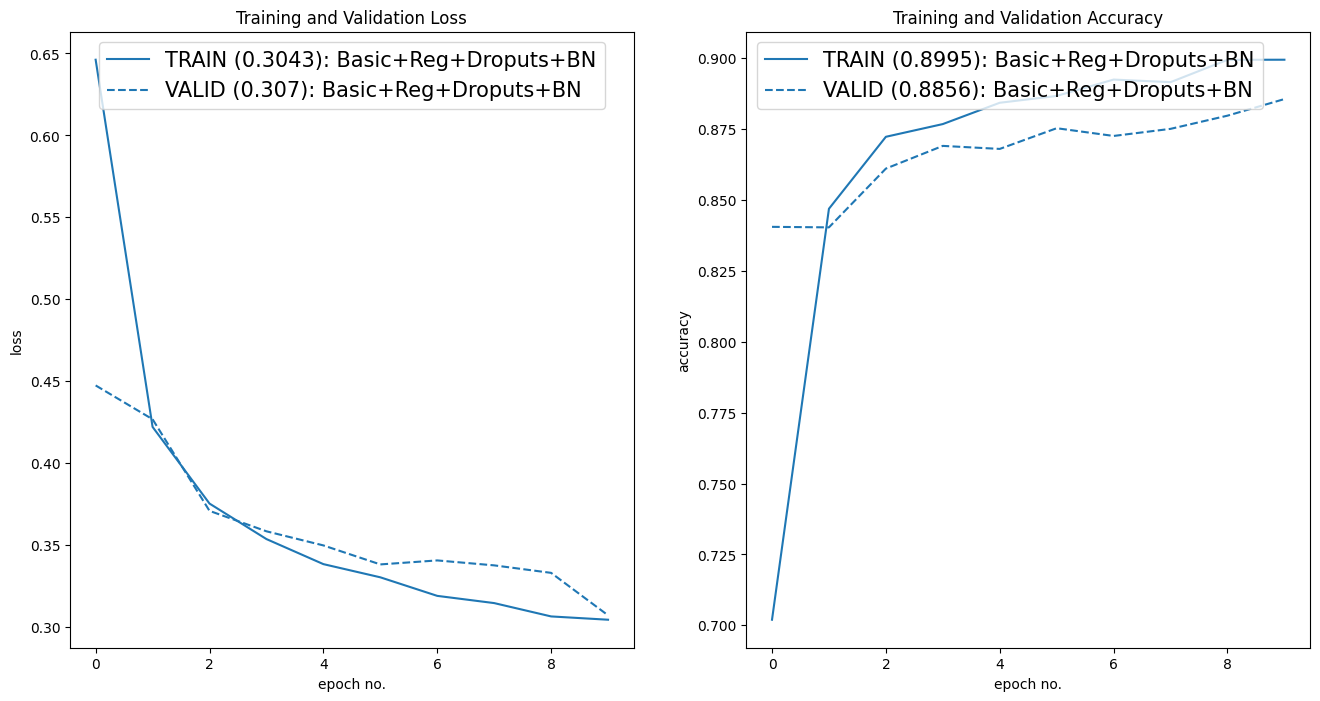

In [ ]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['Basic+Reg+Droputs+BN+LRS'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

## Early Stopping and Checkpoints

Early stopping to stop the training when the loss does not improve after certain epochs.

https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/

https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

In [26]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=True, delta=1e-5, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = "checkpoint.pt"
        self.trace_func = trace_func
    def __call__(self, val_loss, model, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [37]:
# New Model Instance
fas_model4 = FashionMnistModelRegDropoutBN(in_channels=1,
                                           hidden_units=8,
                                           out_channels=10).to(device)
summary(fas_model4, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
       BatchNorm2d-6            [-1, 8, 24, 24]              16
              ReLU-7            [-1, 8, 24, 24]               0
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 10, 10]             584
      BatchNorm2d-11            [-1, 8, 10, 10]              16
             ReLU-12            [-1, 8, 10, 10]               0
          Dropout-13            [-1, 8, 10, 10]               0
           Conv2d-14              [-1, 

In [39]:
# driver setup
reg_type="l2"
reg_coeff=0.0001
lr = 1e-3
#optimizers
if reg_type is not None:
  optimizer = optim.Adam(fas_model4.parameters(), lr=lr)
else:
  # adding l2 reg within optimizer only 3 works exactly same as adding l2 loss with the actual loss
  optimizer = optim.Adam(fas_model4.parameters(), lr=lr, weight_decay=reg_coeff)

#loss metric
criterion = nn.CrossEntropyLoss()

# accuracy metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# diffeent schedulers
plateau_scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10, threshold=0.0001)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)

In [40]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs+5):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(fas_model4, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics, reg_type, reg_coeff, None)
  test_losses , test_metrics = test_module(fas_model4, device, test_loader, criterion, metric, test_losses, test_metrics, plateau_scheduler)
  early_stopping(test_losses[-1], fas_model4, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 0.6572984313405653 Avg Train Metric: 0.6851401242620146: 100%|██████████| 469/469 [00:11<00:00, 39.17it/s]


For current epoch lr: 0.001
Function Took 11.9800 seconds


Avg Test Loss: 0.4975462789776959 Avg Test Metric: 0.8313004042528853: 100%|██████████| 79/79 [00:01<00:00, 64.12it/s]


Function Took 1.2369 seconds
Validation loss decreased (inf --> 0.497546).  Saving model ...
Epoch 1


Avg Train Loss: 0.41509007527502867 Avg Train Metric: 0.851076526174159: 100%|██████████| 469/469 [00:11<00:00, 39.87it/s]


For current epoch lr: 0.001
Function Took 11.7672 seconds


Avg Test Loss: 0.404229792990262 Avg Test Metric: 0.8726421994499013: 100%|██████████| 79/79 [00:01<00:00, 66.09it/s]


Function Took 1.2000 seconds
Validation loss decreased (0.497546 --> 0.404230).  Saving model ...
Epoch 2


Avg Train Loss: 0.3723653057681472 Avg Train Metric: 0.8712121747704203: 100%|██████████| 469/469 [00:11<00:00, 39.22it/s]


For current epoch lr: 0.001
Function Took 11.9631 seconds


Avg Test Loss: 0.3722093784356419 Avg Test Metric: 0.8656221786631814: 100%|██████████| 79/79 [00:01<00:00, 66.30it/s]


Function Took 1.1972 seconds
Validation loss decreased (0.404230 --> 0.372209).  Saving model ...
Epoch 3


Avg Train Loss: 0.34647587157770005 Avg Train Metric: 0.8791304206543131: 100%|██████████| 469/469 [00:11<00:00, 39.61it/s]


For current epoch lr: 0.001
Function Took 11.8462 seconds


Avg Test Loss: 0.3760467779032792 Avg Test Metric: 0.861193424538721: 100%|██████████| 79/79 [00:01<00:00, 65.83it/s]


Function Took 1.2064 seconds
EarlyStopping counter: 1 out of 3
Epoch 4


Avg Train Loss: 0.3311977300689673 Avg Train Metric: 0.8853488647098988: 100%|██████████| 469/469 [00:12<00:00, 38.30it/s]


For current epoch lr: 0.001
Function Took 12.2507 seconds


Avg Test Loss: 0.33461508550975894 Avg Test Metric: 0.8787616415868832: 100%|██████████| 79/79 [00:01<00:00, 64.31it/s]


Function Took 1.2328 seconds
Validation loss decreased (0.372209 --> 0.334615).  Saving model ...
Epoch 5


Avg Train Loss: 0.3203217949885041 Avg Train Metric: 0.8927869107931662: 100%|██████████| 469/469 [00:12<00:00, 38.92it/s]


For current epoch lr: 0.001
Function Took 12.0550 seconds


Avg Test Loss: 0.33861863330195224 Avg Test Metric: 0.8785741887515104: 100%|██████████| 79/79 [00:01<00:00, 65.42it/s]


Function Took 1.2128 seconds
EarlyStopping counter: 1 out of 3
Epoch 6


Avg Train Loss: 0.31151942457598664 Avg Train Metric: 0.8961575842107029: 100%|██████████| 469/469 [00:11<00:00, 39.58it/s]


For current epoch lr: 0.001
Function Took 11.8535 seconds


Avg Test Loss: 0.310073200094549 Avg Test Metric: 0.8862364322324342: 100%|██████████| 79/79 [00:01<00:00, 63.07it/s]


Function Took 1.2574 seconds
Validation loss decreased (0.334615 --> 0.310073).  Saving model ...
Epoch 7


Avg Train Loss: 0.30384885753268626 Avg Train Metric: 0.8993938445790745: 100%|██████████| 469/469 [00:11<00:00, 39.59it/s]


For current epoch lr: 0.001
Function Took 11.8522 seconds


Avg Test Loss: 0.3155198664982108 Avg Test Metric: 0.8908771487730968: 100%|██████████| 79/79 [00:01<00:00, 66.27it/s]


Function Took 1.1965 seconds
EarlyStopping counter: 1 out of 3
Epoch 8


Avg Train Loss: 0.29964756549421406 Avg Train Metric: 0.9006831409580418: 100%|██████████| 469/469 [00:11<00:00, 39.53it/s]


For current epoch lr: 0.001
Function Took 11.8693 seconds


Avg Test Loss: 0.3019844882095916 Avg Test Metric: 0.8958792648737943: 100%|██████████| 79/79 [00:01<00:00, 66.08it/s]


Function Took 1.2002 seconds
Validation loss decreased (0.310073 --> 0.301984).  Saving model ...
Epoch 9


Avg Train Loss: 0.2947399309639738 Avg Train Metric: 0.9017155615251455: 100%|██████████| 469/469 [00:11<00:00, 39.76it/s]


For current epoch lr: 0.001
Function Took 11.8001 seconds


Avg Test Loss: 0.3138625921705101 Avg Test Metric: 0.8875287680686275: 100%|██████████| 79/79 [00:01<00:00, 66.94it/s]


Function Took 1.1843 seconds
EarlyStopping counter: 1 out of 3
Epoch 10


Avg Train Loss: 0.2902641335148801 Avg Train Metric: 0.9045699246402489: 100%|██████████| 469/469 [00:11<00:00, 39.20it/s]


For current epoch lr: 0.001
Function Took 11.9696 seconds


Avg Test Loss: 0.3020050963269004 Avg Test Metric: 0.8926272867601129: 100%|██████████| 79/79 [00:01<00:00, 65.80it/s]


Function Took 1.2056 seconds
EarlyStopping counter: 2 out of 3
Epoch 11


Avg Train Loss: 0.2877375997904775 Avg Train Metric: 0.9037326186704737: 100%|██████████| 469/469 [00:11<00:00, 39.73it/s]


For current epoch lr: 0.001
Function Took 11.8110 seconds


Avg Test Loss: 0.3020232940399194 Avg Test Metric: 0.8947026073178158: 100%|██████████| 79/79 [00:01<00:00, 66.37it/s]

Function Took 1.1946 seconds
EarlyStopping counter: 3 out of 3
Early stopping


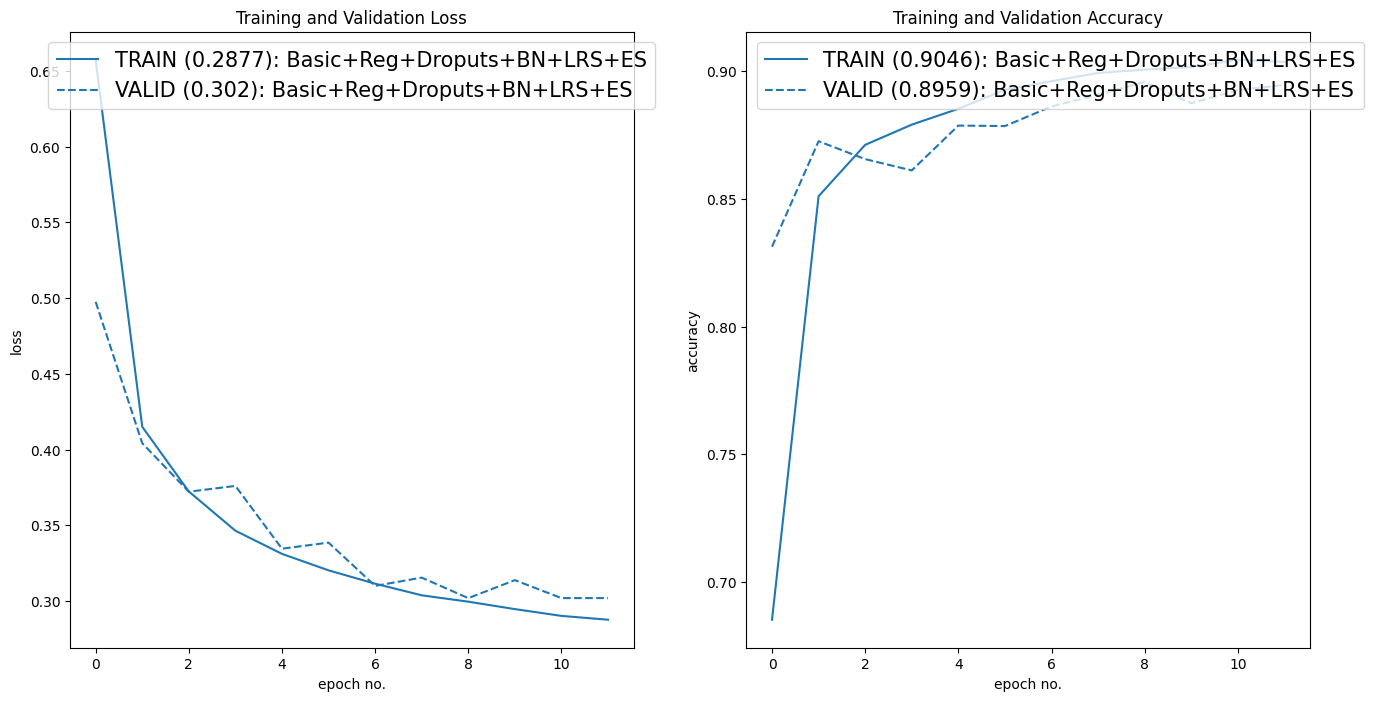

In [41]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['Basic+Reg+Droputs+BN+LRS+ES'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

## Weights Initialization


Random Initalization

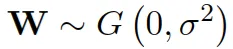

The problem of the random initialization is that it may lead to vanishing or exploding layer outputs in the deep neural network, depending on the variance of Gaussian distribution.If the variance of initial weights is set too small, the variance of layer outputs may be extremely small or vanishing due to the accumulation of small variance during forward propagation. On the contrary, if the variance of initial weights is set too large, the variance of layer outputs may be extremely large or exploding due to the accumulation of large variance during forward propagation
Xavier initialization [2] and He’s initialization [3] are two solutions that are designed to maintain variance during forward propagation and during backward propagation.

Xavier Initialization

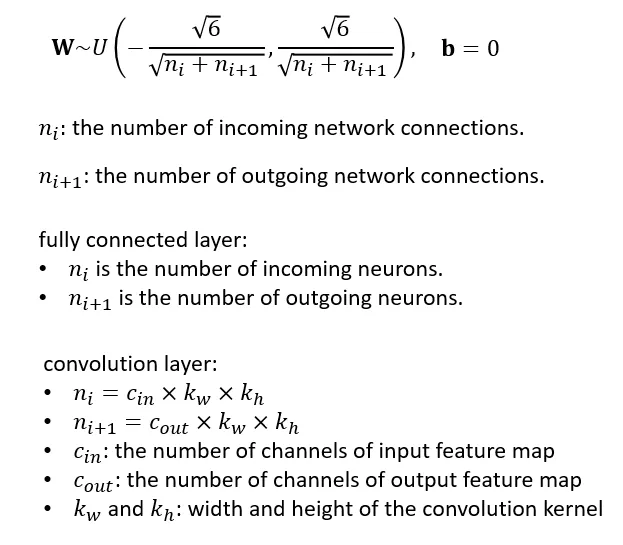

 Xavier initialization approach maintains the variance of layer outputs during forward propagation and the variance of weight gradients during backward propagation for a five-layer network using hyperbolic tangent (tanh) activation. However, Xavier initialization is designed for tanh or sigmoid activation, and may lead to a reduction of gradients during back propagation due to the vanishing gradient problem caused by tanh or sigmoid. Therefore, Xavier initialization may not be suitable for a deep neural network using ReLU activation.

He’s Initialization

designed for deep neural network with the ReLU activation that helps to reduce the vanishing gradient problem, allows the network to learn deeper representations. He’s initialization draws the weights of one layer in the network from Gaussian distribution

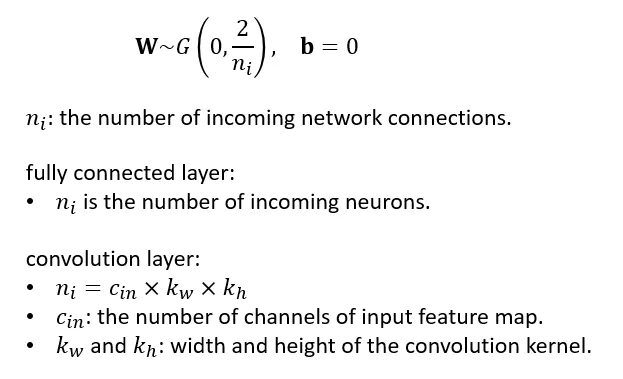

Batch norm layers normalize the distribution of layer outputs during training, which reduces the dependency of the deep network on weight initialization strategies [4]. The weights and biases of all batch normalization layers are usually initialized as 1s and 0s, respectively.

##### Weight Init when using nn.Module independent layers

In [36]:
def custom_weight_module(module):
  """ Custom weight module initialization function for nn.Module independent layers."""

  if isinstance(module, nn.Conv2d):
      nn.init.kaiming_uniform_(tensor=module.weight, nonlinearity="relu", mode="fan_in")
      if module.bias is not None:
          nn.init.zeros_(module.bias)

  elif isinstance(module, nn.Linear):
      nn.init.kaiming_normal_(tensor=module.weight, nonlinearity="relu", mode="fan_in")
      nn.init.zeros_(module.bias)

  elif isinstance(module, (nn.BatchNorm1d, nn.GroupNorm, nn.BatchNorm2d)):
      nn.init.constant_(module.weight, 1.0)
      nn.init.constant_(module.bias, 0.0)

##### Weight Init when using nn.Sequential layer to club multiple NN modules

In [28]:
def custom_weight_sequential(module):
  """ Custom weight initialization function for nn.Sequential layer to club multiple NN modules."""

  classname = module.__class__.__name__
  if classname.find("Conv") != -1:
      nn.init.kaiming_uniform_(tensor=module.weight, nonlinearity="relu", mode="fan_in")
      if module.bias is not None:
          nn.init.zeros_(module.bias)

  elif classname.find("BatchNorm") != -1:
      nn.init.constant_(module.weight, 1.0)
      nn.init.constant_(module.bias, 0.0)

  elif classname.find("Linear") != -1:
      nn.init.kaiming_normal_(tensor=module.weight, nonlinearity="relu", mode="fan_in")
      nn.init.zeros_(module.bias)

In [44]:
# New Model Instance
fas_model5 = FashionMnistModelRegDropoutBN(in_channels=1,
                                           hidden_units=10,
                                           out_channels=10).to(device)
summary(fas_model5, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             910
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 10, 10, 10]             910
      BatchNorm2d-11           [-1, 10, 10, 10]              20
             ReLU-12           [-1, 10, 10, 10]               0
          Dropout-13           [-1, 10, 10, 10]               0
           Conv2d-14             [-1, 1

In [45]:
# for keys,value in fas_model5.state_dict().items():
#   print(keys)
#   print(value.sum())

In [46]:
fas_model5.apply(custom_weight_sequential)

FashionMnistModelRegDropoutBN(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Max

In [47]:
# for keys,value in fas_model5.state_dict().items():
#   print(keys)
#   print(value.sum())

In [48]:
# driver setup
reg_type="l2"
reg_coeff=0.0001
lr = 1e-3
#optimizers
if reg_type is not None:
  optimizer = optim.Adam(fas_model5.parameters(), lr=lr)
else:
  # adding l2 reg within optimizer only 3 works exactly same as adding l2 loss with the actual loss
  optimizer = optim.Adam(fas_model5.parameters(), lr=lr, weight_decay=reg_coeff)

#loss metric
criterion = nn.CrossEntropyLoss()

# accuracy metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# diffeent schedulers
plateau_scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10, threshold=0.0001)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)

In [49]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs+5):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(fas_model5, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics, reg_type, reg_coeff, None)
  test_losses , test_metrics = test_module(fas_model5, device, test_loader, criterion, metric, test_losses, test_metrics, plateau_scheduler)
  early_stopping(test_losses[-1], fas_model5, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 0.7461264438466477 Avg Train Metric: 0.6487274731336626: 100%|██████████| 469/469 [00:19<00:00, 24.34it/s]


For current epoch lr: 0.001
Function Took 19.2782 seconds


Avg Test Loss: 0.5531407696536824 Avg Test Metric: 0.7878587359114538: 100%|██████████| 79/79 [00:01<00:00, 48.35it/s]


Function Took 1.6409 seconds
Validation loss decreased (inf --> 0.553141).  Saving model ...
Epoch 1


Avg Train Loss: 0.5091208167421792 Avg Train Metric: 0.8184699079375277: 100%|██████████| 469/469 [00:19<00:00, 24.13it/s]


For current epoch lr: 0.001
Function Took 19.4411 seconds


Avg Test Loss: 0.4497137130061282 Avg Test Metric: 0.8352888513214981: 100%|██████████| 79/79 [00:01<00:00, 49.90it/s]


Function Took 1.5891 seconds
Validation loss decreased (0.553141 --> 0.449714).  Saving model ...
Epoch 2


Avg Train Loss: 0.4477296402967815 Avg Train Metric: 0.8480608559874837: 100%|██████████| 469/469 [00:19<00:00, 24.27it/s]


For current epoch lr: 0.001
Function Took 19.3289 seconds


Avg Test Loss: 0.4380152546152284 Avg Test Metric: 0.8396076801456983: 100%|██████████| 79/79 [00:01<00:00, 48.13it/s]


Function Took 1.6458 seconds
Validation loss decreased (0.449714 --> 0.438015).  Saving model ...
Epoch 3


Avg Train Loss: 0.4117502507243329 Avg Train Metric: 0.8618869135883063: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]


For current epoch lr: 0.001
Function Took 20.1952 seconds


Avg Test Loss: 0.3573416786480553 Avg Test Metric: 0.8678591704066796: 100%|██████████| 79/79 [00:01<00:00, 44.37it/s]


Function Took 1.7851 seconds
Validation loss decreased (0.438015 --> 0.357342).  Saving model ...
Epoch 4


Avg Train Loss: 0.38412544067734594 Avg Train Metric: 0.8746845665008529: 100%|██████████| 469/469 [00:19<00:00, 24.54it/s]


For current epoch lr: 0.001
Function Took 19.1173 seconds


Avg Test Loss: 0.38774632992623725 Avg Test Metric: 0.8588436268552949: 100%|██████████| 79/79 [00:01<00:00, 49.17it/s]


Function Took 1.6153 seconds
EarlyStopping counter: 1 out of 3
Epoch 5


Avg Train Loss: 0.3660641938193775 Avg Train Metric: 0.8806472435943099: 100%|██████████| 469/469 [00:18<00:00, 24.92it/s]


For current epoch lr: 0.001
Function Took 18.8247 seconds


Avg Test Loss: 0.3344450675988499 Avg Test Metric: 0.8738943293124815: 100%|██████████| 79/79 [00:01<00:00, 49.93it/s]


Function Took 1.5877 seconds
Validation loss decreased (0.357342 --> 0.334445).  Saving model ...
Epoch 6


Avg Train Loss: 0.35089245486234044 Avg Train Metric: 0.8848416601925262: 100%|██████████| 469/469 [00:18<00:00, 24.97it/s]


For current epoch lr: 0.001
Function Took 18.7851 seconds


Avg Test Loss: 0.32290705868714975 Avg Test Metric: 0.881801187992096: 100%|██████████| 79/79 [00:01<00:00, 47.66it/s]


Function Took 1.6633 seconds
Validation loss decreased (0.334445 --> 0.322907).  Saving model ...
Epoch 7


Avg Train Loss: 0.3379036440396868 Avg Train Metric: 0.8927668095397543: 100%|██████████| 469/469 [00:18<00:00, 25.21it/s]


For current epoch lr: 0.001
Function Took 18.6127 seconds


Avg Test Loss: 0.3175254077473773 Avg Test Metric: 0.882842563375642: 100%|██████████| 79/79 [00:01<00:00, 48.64it/s]


Function Took 1.6318 seconds
Validation loss decreased (0.322907 --> 0.317525).  Saving model ...
Epoch 8


Avg Train Loss: 0.32897270675788304 Avg Train Metric: 0.895840073572293: 100%|██████████| 469/469 [00:18<00:00, 25.09it/s]


For current epoch lr: 0.001
Function Took 18.7022 seconds


Avg Test Loss: 0.30298776471916633 Avg Test Metric: 0.8894608805451212: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Function Took 1.6930 seconds
Validation loss decreased (0.317525 --> 0.302988).  Saving model ...
Epoch 9


Avg Train Loss: 0.3204021920273299 Avg Train Metric: 0.897885228906359: 100%|██████████| 469/469 [00:18<00:00, 24.96it/s]


For current epoch lr: 0.001
Function Took 18.7996 seconds


Avg Test Loss: 0.29657184653267077 Avg Test Metric: 0.8825973083701315: 100%|██████████| 79/79 [00:01<00:00, 46.29it/s]


Function Took 1.7126 seconds
Validation loss decreased (0.302988 --> 0.296572).  Saving model ...
Epoch 10


Avg Train Loss: 0.313921041357746 Avg Train Metric: 0.9012820746090366: 100%|██████████| 469/469 [00:18<00:00, 24.87it/s]


For current epoch lr: 0.001
Function Took 18.8629 seconds


Avg Test Loss: 0.2989629193951812 Avg Test Metric: 0.8878981252259845: 100%|██████████| 79/79 [00:01<00:00, 48.88it/s]


Function Took 1.6216 seconds
EarlyStopping counter: 1 out of 3
Epoch 11


Avg Train Loss: 0.3084466777948428 Avg Train Metric: 0.9042006509898822: 100%|██████████| 469/469 [00:18<00:00, 25.07it/s]


For current epoch lr: 0.001
Function Took 18.7106 seconds


Avg Test Loss: 0.2924798838322676 Avg Test Metric: 0.8929367978361589: 100%|██████████| 79/79 [00:01<00:00, 47.23it/s]


Function Took 1.6786 seconds
Validation loss decreased (0.296572 --> 0.292480).  Saving model ...
Epoch 12


Avg Train Loss: 0.30406696452642046 Avg Train Metric: 0.9028844558862227: 100%|██████████| 469/469 [00:18<00:00, 25.01it/s]


For current epoch lr: 0.001
Function Took 18.7595 seconds


Avg Test Loss: 0.29849586249152316 Avg Test Metric: 0.8900171208985245: 100%|██████████| 79/79 [00:01<00:00, 47.86it/s]


Function Took 1.6562 seconds
EarlyStopping counter: 1 out of 3
Epoch 13


Avg Train Loss: 0.2993965456798387 Avg Train Metric: 0.9058771198238137: 100%|██████████| 469/469 [00:18<00:00, 24.99it/s]


For current epoch lr: 0.001
Function Took 18.7801 seconds


Avg Test Loss: 0.2896321004704584 Avg Test Metric: 0.8912970687769637: 100%|██████████| 79/79 [00:01<00:00, 47.28it/s]


Function Took 1.6769 seconds
Validation loss decreased (0.292480 --> 0.289632).  Saving model ...
Epoch 14


Avg Train Loss: 0.2942414001933039 Avg Train Metric: 0.9088122948908857: 100%|██████████| 469/469 [00:18<00:00, 24.82it/s]


For current epoch lr: 0.001
Function Took 18.9014 seconds


Avg Test Loss: 0.2772731196276749 Avg Test Metric: 0.8956829505630687: 100%|██████████| 79/79 [00:01<00:00, 47.11it/s]

Function Took 1.6831 seconds
Validation loss decreased (0.289632 --> 0.277273).  Saving model ...


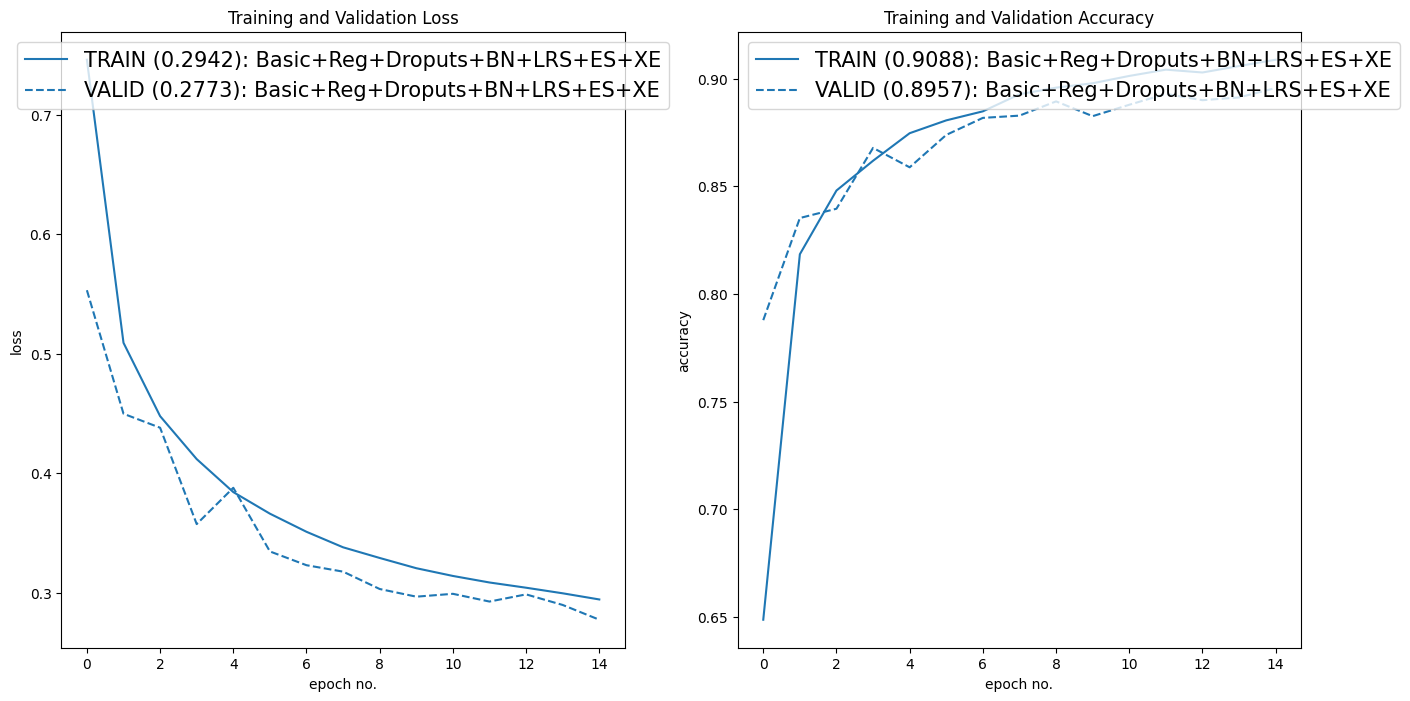

In [50]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['Basic+Reg+Droputs+BN+LRS+ES+XE'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

## Best Reference
https://www.kaggle.com/code/enwei26/mnist-digits-pytorch-cnn-99/notebook

In [ ]:
%load_ext watermark
%watermark -v -p numpy,torch,torchvision,tqdm,matplotlib,torcheval

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy      : 1.25.2
torch      : 2.1.0+cu121
torchvision: 0.16.0+cu121
tqdm       : 4.66.2
matplotlib : 3.7.1
torcheval  : 0.0.7

